Found 150 Pokémon categories:
['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise']

Showing 5 images from 'MrMime'


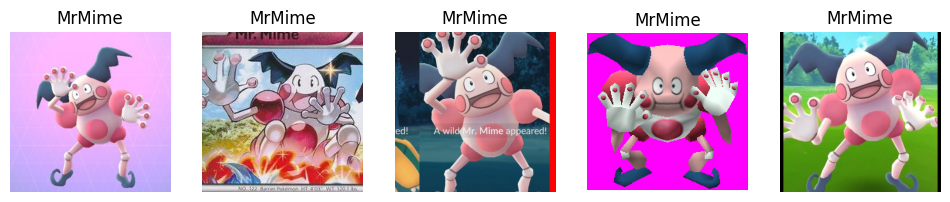

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Path to the image dataset

path = "PokemonData"

# List all Pokémon folders
pokemon_folders = os.listdir(path)
print(f"Found {len(pokemon_folders)} Pokémon categories:")
print(pokemon_folders[:10])  # show first 10 folder names

# Pick one Pokémon folder at random
pokemon = random.choice(pokemon_folders)
pokemon_path = os.path.join(path, pokemon)

# Get up to 5 image filenames
images = [f for f in os.listdir(pokemon_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]

print(f"\nShowing {len(images)} images from '{pokemon}'")

# Display images
plt.figure(figsize=(12, 4))
for i, img_name in enumerate(images):
    img_path = os.path.join(pokemon_path, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(pokemon)
plt.show()



Showing 5 images from 'Magmar'


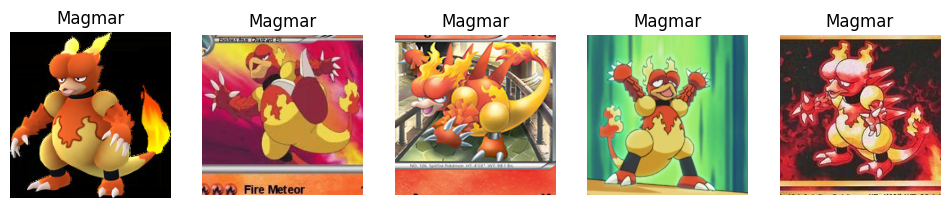

In [2]:
# Pick one Pokémon folder at random
pokemon = random.choice(pokemon_folders)
pokemon_path = os.path.join(path, pokemon)

# Get up to 5 image filenames
images = [f for f in os.listdir(pokemon_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]

print(f"\nShowing {len(images)} images from '{pokemon}'")
# Display images
plt.figure(figsize=(12, 4))
for i, img_name in enumerate(images):
    img_path = os.path.join(pokemon_path, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(pokemon)
plt.show()

In [5]:

import torch
import torch.nn as nn
import torch_directml
import time

# Pick DirectML device
dml = torch_directml.device()

name = torch_directml.device_name(0)
print(name)


AMD Radeon RX 9060 XT 


In [4]:
import torch_directml

# Get the count first
gpu_count = torch_directml.device_count()

print("Available DirectML Devices:")

# Iterate through the available devices
for i in range(gpu_count):
    # This function retrieves the name of the device at the given index
    name = torch_directml.device_name(i)
    
    print(f"Device Index {i}: {name}")

# The device object used in code is 'dml' followed by the index
# dml_device_0 = torch_directml.device(i)


Available DirectML Devices:
Device Index 0: AMD Radeon RX 9060 XT 


In [ ]:
# Data Loading
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Reshaping input image
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder('./PokemonData', transform=transform)

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False)

In [6]:
# GPU setup
device = torch_directml.device()

# Model Creation
class PokemonCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64

            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32

            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16

            nn.Flatten(),
            nn.Linear(128*16*16, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

num_classes = len(dataset.classes)
model = PokemonCNN(num_classes).to(device)


In [7]:
# Model Training

import torch
from torch import nn, optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def one_epoch_train(model, loader, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)                 # forward
        loss = criterion(out, y)       # loss
        loss.backward()                # grad
        optimizer.step()               # update

        running_loss += loss.item() * y.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return running_loss/total, correct/total

@torch.no_grad()
def eval_acc(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct/total

# Train a few epochs
for epoch in range(5):
    train_loss, train_acc = one_epoch_train(model, train_dl, device)
    val_acc = eval_acc(model, val_dl, device)
    print(f"Epoch {epoch+1}: loss={train_loss:.4f}  train_acc={train_acc:.3f}  val_acc={val_acc:.3f}")


torch.save(model.state_dict(), "models/pokemon_basic.pt")

c:\Users\Nick\miniconda3\envs\poke\lib\site-packages\torch\optim\adam.py:534: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)


Epoch 1: loss=4.7356  train_acc=0.024  val_acc=0.063
Epoch 2: loss=3.6109  train_acc=0.148  val_acc=0.181
Epoch 3: loss=2.6764  train_acc=0.336  val_acc=0.345
Epoch 4: loss=1.7948  train_acc=0.525  val_acc=0.422
Epoch 5: loss=1.0913  train_acc=0.698  val_acc=0.444


In [8]:
# Model 2
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(3),

            nn.Conv2d(in_channels=24, out_channels=42, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(42, 100, kernel_size=2, stride=2), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(100, 162, kernel_size=3, stride=1, padding=0), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(1458, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

num_classes = len(dataset.classes)
model = MyCNN(num_classes).to(device)

In [9]:
# Training Model 2
import torch
from torch import nn, optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def one_epoch_train(model, loader, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)                 # forward
        loss = criterion(out, y)       # loss
        loss.backward()                # grad
        optimizer.step()               # update

        running_loss += loss.item() * y.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return running_loss/total, correct/total

@torch.no_grad()
def eval_acc(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct/total

# Train a few epochs
for epoch in range(5):
    train_loss, train_acc = one_epoch_train(model, train_dl, device)
    val_acc = eval_acc(model, val_dl, device)
    print(f"Epoch {epoch+1}: loss={train_loss:.4f}  train_acc={train_acc:.3f}  val_acc={val_acc:.3f}")


torch.save(model.state_dict(), "models/pokemon_basic.pt")

AttributeError: 'MyCNN' object has no attribute 'net'